Parte de los métodos mostrados aquí han sido tomados del siguiente documento y adaptados a otros usos de caso de:
*texto en cursiva*
*Skforecast: time series forecasting with Python, Machine Learning and Scikit-learn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) at* https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

bajo la licencia:
https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en#ref-same-license





# 1. Base de datos

https://www.kaggle.com/datasets/yasserh/walmart-dataset

This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales. Within this file you will find the following fields:

Store - the store number

Date - the week of sales

Weekly_Sales - sales for the given store

Holiday_Flag - whether the week is a special holiday

week 1 – Holiday week 0 – Non-holiday week

Temperature - Temperature on the day of sale

Fuel_Price - Cost of fuel in the region

CPI – Prevailing consumer price index

Unemployment - Prevailing unemployment rate

Holiday Events<br />

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13<br />
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13<br />
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13<br />
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
plt.style.use('ggplot')
pd.set_option("display.max_columns", None)


import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/walmart-dataset")

print("Path to dataset files:", path)
df = pd.read_csv(path+'/Walmart.csv')

Path to dataset files: /kaggle/input/walmart-dataset


In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df['date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.drop('Date',axis=1,inplace=True)

In [ ]:
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05
...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,2012-09-28
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,2012-10-05
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,2012-10-12
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,2012-10-19


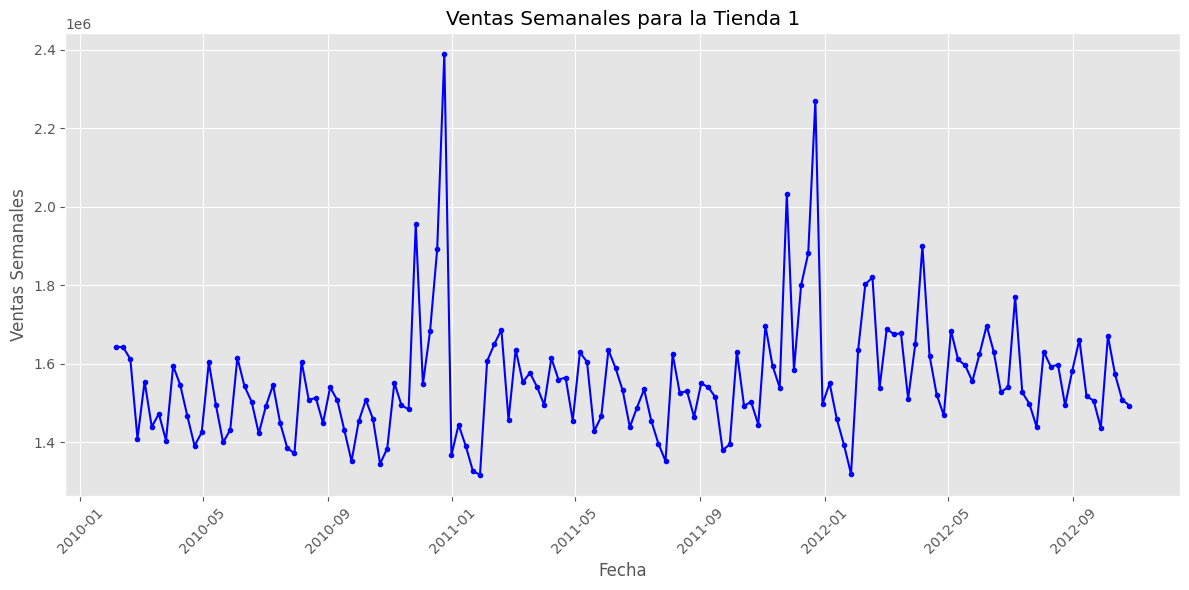

In [ ]:
store1_data = df[df['Store'] == 1]

# Crea el gráfico
plt.figure(figsize=(12, 6))
plt.plot(store1_data['date'], store1_data['Weekly_Sales'],".",ls="-",color='blue')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales')
plt.title('Ventas Semanales para la Tienda 1')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Características de una serie de tiempo

## 2.1 Estacionariedad


Una serie temporal se considera estacionaria si no hay un cambio sistemático en la media, es decir, no hay una tendencia, y no hay un cambio sistemático en la variación. En una serie temporal estacionaria, las propiedades de la serie en una sección de datos son muy similares a las propiedades de la serie temporal en otra sección. Para ser más precisos, la estacionariedad es una propiedad de un proceso estocástico y, dado que modelamos series temporales con procesos estocásticos, también definimos la estacionariedad para series temporales. Hay varias definiciones de estacionariedad, pero nos enfocaremos en la "estacionariedad de segundo orden".


Dada una serie $x_t$, la serie es estacionaria si:

* $E[x_t] = \mu_t\,\,\,(constante)$
* $Var(x_t)=V_{0}\,\,\,(constante)$
* $Cov(x_t,x_{t+k})=V_k$ (depende sólo de la diferencia en tiempo k)

Si una serie no es estacionaria, se puede transformar en estacionaria aplicando la "diferenciación" (una o más veces), que consiste en considerar una nueva serie $y_t$:

$y_t=x_t-x_{t-1}$

Dickey-Fuller test

La prueba está basada en las hipótesis:

* Hipótesis nula (HO): La serie **NO ES** estacionaria

* Hipótesis alternativa (HA): La serie **ES** estacionaria

Si el estadístico de prueba es menor que el valor crítico y p-value < 0.05 (u otro novel de significancia) se rechaza la hipótesis nula (H0) y la serie $\bf{es\,estacionaria}$.

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

La prueba está basada en las hipótesis:

* Hipótesis nula (HO): La serie **ES** estacionaria

* Hipótesis alternativa (HA): La serie **NO ES** estacionaria

Si p-value < 0.05 (u otro nivel de significancia), **la series no es estacionaria**.

¿Cuál es la prueba mejor?

La estrategia sugerida es aplicar ambas pruebas:

- Ambas pruebas concluyen que la serie dada es estacionaria – La serie es estacionaria

- Ambas pruebas concluyen que la serie dada es no estacionaria – La serie es no estacionaria

- DF concluye no estacionaria y KPSS concluye estacionaria – La serie es estacionaria con tendencia. Para hacer que la serie sea estrictamente estacionaria, es necesario eliminar la tendencia en este caso. Luego, se verifica la estacionariedad de la serie sin tendencia.

- DF concluye estacionaria y KPSS concluye no estacionaria – La serie es estacionaria en diferencias. Se debe utilizar la diferenciación para hacer que la serie sea estacionaria. Luego, se verifica la estacionariedad de la serie diferenciada.

https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=A%20Stationary%20series%20is%20one,a%20Trend%20or%20Seasonal%20components.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# Prueba de Dickey-Fuller aumentada (ADF)
result_adf = adfuller(store1_data['Weekly_Sales'])
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

# Prueba de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
result_kpss = kpss(store1_data['Weekly_Sales'])
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.102186
p-value: 0.000014
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578

KPSS Statistic: 0.475894
p-value: 0.047096
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


## 2.2 Estacionalidad

La presencia de estacionalidad se puede analizar gráficamente con la serie original o después de la decomposición de tendencia y estacionalidad.

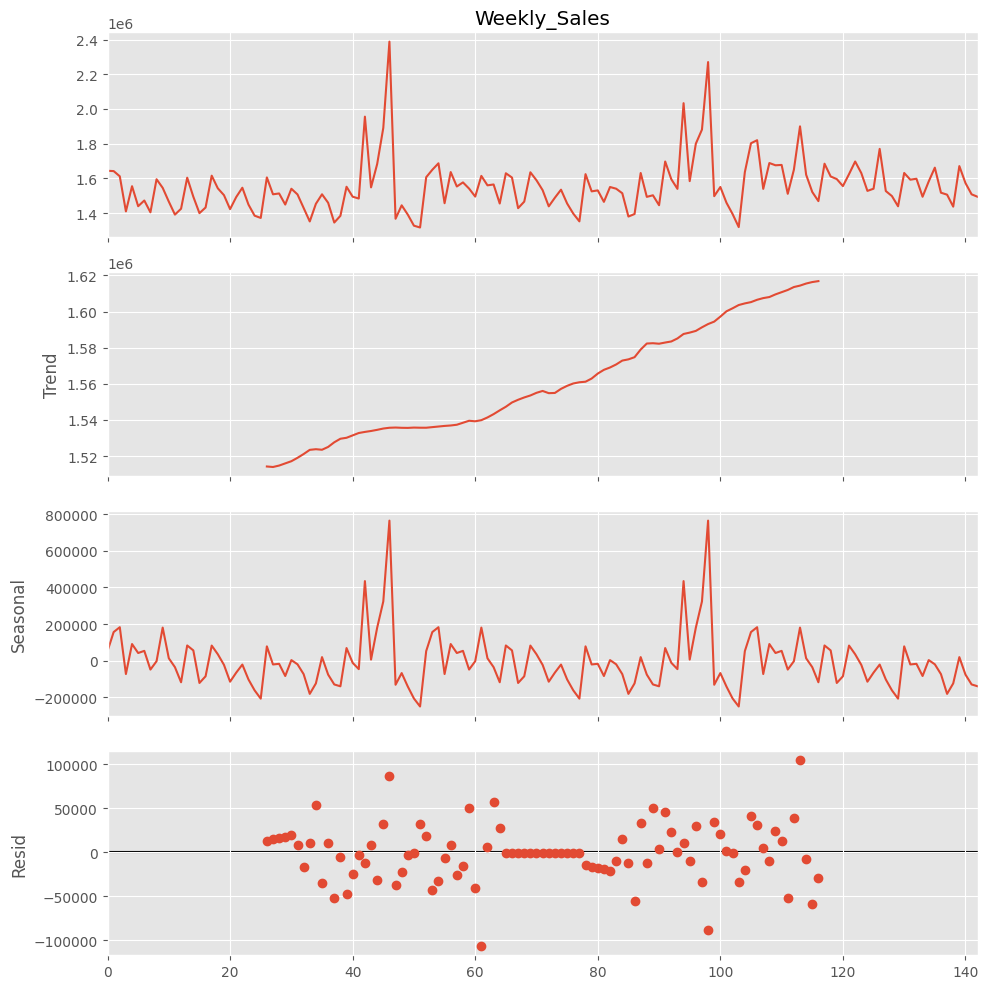

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(store1_data['Weekly_Sales'], model='additive', period=52) # period=52 for weekly data

# Gráfico de los componentes
plt.rcParams.update({'figure.figsize': (10,10)})
decomposition.plot()
plt.show()


Se puede también hacer un análisis de las frecuencias para individuar los periodos principales de la serie.

<ipython-input-9-fb2b6f79c122>:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/f, Pxx)


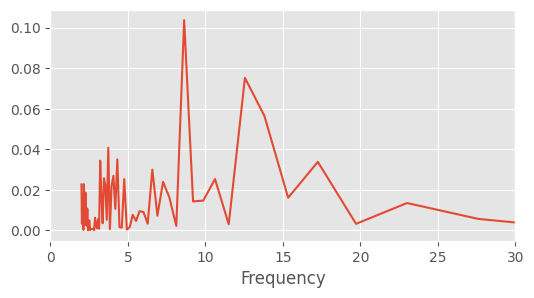

In [ ]:
from scipy import signal
tslog = np.log(store1_data['Weekly_Sales'])
rollavg = tslog.rolling(6).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)

f, Pxx = signal.periodogram(tslogdiff)
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(1/f, Pxx)
plt.xlabel('Frequency')
ax.set_xlim(0,30)
plt.show()

In [ ]:
top_4_periods = {}

# get indices for 4 highest Pxx values
top4_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]


freqs = f[top4_freq_indices]

# use same indices to get powers as well
power = Pxx[top4_freq_indices]

# we are interested in period and it is calculated as 1/frequency
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_4_periods['period1'] = periods[0]
top_4_periods['freq1'] = freqs[0]
top_4_periods['power1'] = power[0]

top_4_periods['period2'] = periods[1]
top_4_periods['freq2'] = freqs[1]
top_4_periods['power2'] = power[1]

top_4_periods['period3'] = periods[2]
top_4_periods['freq3'] = freqs[2]
top_4_periods['power3'] = power[2]

top_4_periods['period4'] = periods[3]
top_4_periods['freq4'] = freqs[3]
top_4_periods['power4'] = power[3]
top_4_periods

{'period1': np.float64(8.625),
 'freq1': np.float64(0.11594202898550725),
 'power1': np.float64(0.10366914639396715),
 'period2': np.float64(12.545454545454545),
 'freq2': np.float64(0.07971014492753624),
 'power2': np.float64(0.07521869063083345),
 'period3': np.float64(13.799999999999999),
 'freq3': np.float64(0.07246376811594203),
 'power3': np.float64(0.05652873689176022),
 'period4': np.float64(3.7297297297297294),
 'freq4': np.float64(0.26811594202898553),
 'power4': np.float64(0.04081724157968489)}

## 2.3 Funciones de autocorrelación y autocorrelación parcial (ACF - PACF)


ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function) son herramientas fundamentales en el análisis de series de tiempo. Sirven para entender la estructura de autocorrelación en una serie temporal y ayudan a identificar patrones y modelos adecuados para describir y predecir la serie.

ACF (Autocorrelation Function)

La función de autocorrelación (ACF) mide la correlación entre una serie temporal y los valores de la serie en "lags" anteriores. (Si la serie actual es $x_t$, el lag 1 corresponde al valor de la serie en t-1).   En otras palabras, mide la relación entre los valores actuales y los valores pasados de la serie.

La ACF se utiliza para:

Identificar patrones de autocorrelación: La ACF ayuda a detectar si hay una relación significativa entre los valores actuales y los valores pasados de la serie.

Determinar la presencia de tendencias o estacionalidad: La ACF puede indicar si hay una tendencia o estacionalidad en la serie.

Seleccionar modelos de series temporales: La ACF se utiliza para determinar el orden de los modelos de medias móviles (MA) y modelos autorregresivos (AR).

PACF (Partial Autocorrelation Function)

La función de autocorrelación parcial (PACF) mide la correlación entre una serie temporal y los valores en lags anteriores , eliminando el efecto de las variables intermedias.

La PACF se utiliza para:

Identificar la relación directa entre valores: La PACF ayuda a detectar la relación directa entre los valores actuales y los valores pasados de la serie, sin la influencia de variables intermedias.

Determinar el orden de los modelos autorregresivos (AR): La PACF se utiliza para determinar el orden del modelo AR, ya que puede indicar cuántos términos autorregresivos son necesarios para modelar la serie.

Uso conjunto de ACF y PACF

Al analizar conjuntamente la ACF y la PACF, se pueden obtener conclusiones valiosas sobre la estructura de la serie temporal y seleccionar modelos adecuados para describir y predecir la serie. Por ejemplo:

Si la ACF disminuye lentamente y la PACF se corta después de un cierto número de retardos, puede indicar un modelo AR.

Si la ACF se corta después de un cierto número de retardos y la PACF disminuye lentamente, puede indicar un modelo MA.

Si tanto la ACF como la PACF disminuyen lentamente, puede indicar un modelo ARMA (autorregresivo y de medias móviles).

En resumen, la ACF y la PACF son herramientas esenciales en el análisis de series de tiempo que ayudan a entender la estructura de autocorrelación y seleccionar modelos adecuados para describir y predecir la serie.


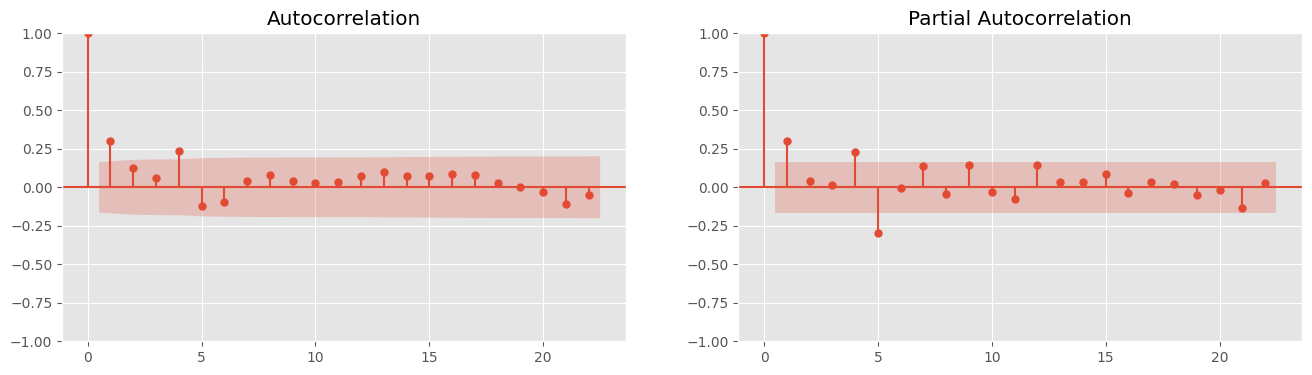

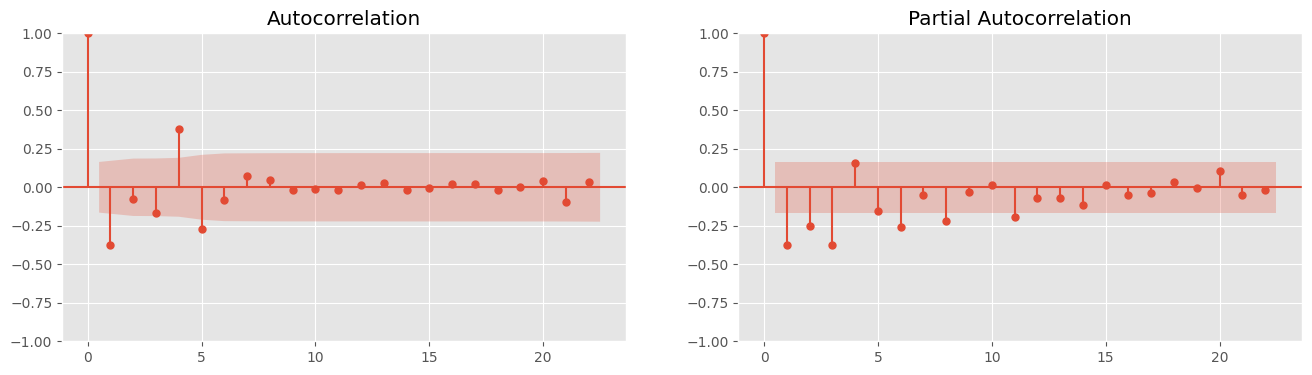

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelación y autocorrelación parcial para la serie original
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(store1_data['Weekly_Sales'], ax=axes[0])
plot_pacf(store1_data['Weekly_Sales'], ax=axes[1])
plt.show()


# Autocorrelación y autocorrelación parcial para la serie diferenciada
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(store1_data['Weekly_Sales'].diff().dropna(),ax=axes[0])
plot_pacf(store1_data['Weekly_Sales'].diff().dropna(), ax=axes[1])
plt.show()


# HOLT WINTERS

El método de Holt-Winters es una técnica de suavización exponencial utilizada para predecir series temporales que presentan tendencia y estacionalidad. Es una extensión del método de suavización exponencial simple y doble, y se utiliza comúnmente para predecir series temporales que tienen un patrón estacional y una tendencia lineal o no lineal.

Componentes del método de Holt-Winters

El método de Holt-Winters se basa en tres componentes:
- Nivel (L): Representa el valor promedio de la serie temporal en un momento dado.

- Tendencia (T): Representa la dirección y la magnitud de la tendencia en la serie temporal.

- Estacionalidad (S): Representa el patrón estacional en la serie temporal.

Ecuaciones del método de Holt-Winters

El método de Holt-Winters utiliza las siguientes ecuaciones para actualizar los componentes:

- Nivel: $L_t = α (Y_t - S_{t-m}) + (1 - α) (L_{t-1} + T_{t-1})$
- Tendencia: $T_t = β (L_t - L_{t-1}) + (1 - β) T_{t-1}$
- Estacionalidad: $S_t = γ (Y_t - L_t) + (1 - γ) S_{t-m}$
donde:

$Y_t$ es el valor observado en el momento t

$L_t$ es el nivel en el momento t

$T_t$ es la tendencia en el momento t

$S_t$ es la estacionalidad en el momento t

El pronóstico es dado por:

$\hat{Y}_{t+p}=(L_t+pT_t)S_{t-s+p}$


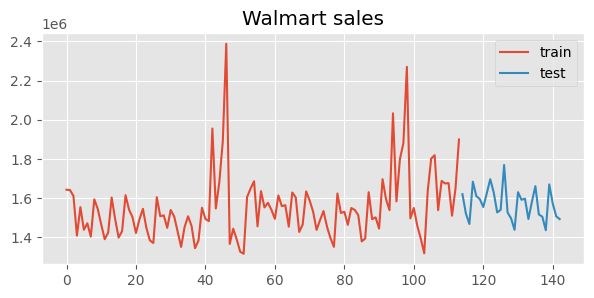

In [ ]:
train_size = int(len(store1_data) * 0.80)
train_data = store1_data[:train_size]
test_data = store1_data[train_size:]

fig, ax=plt.subplots(figsize=(7, 3))
train_data['Weekly_Sales'].plot(ax=ax, label='train')
test_data['Weekly_Sales'].plot(ax=ax, label='test')
ax.set_title('Walmart sales')
ax.legend();


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


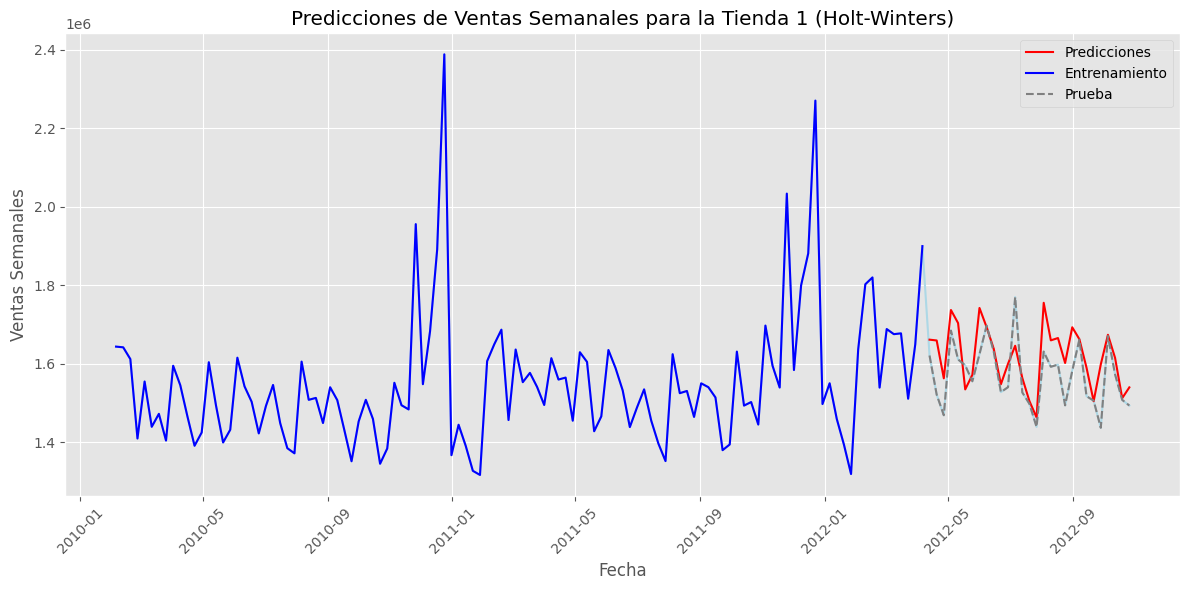

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing



model = ExponentialSmoothing(train_data['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52) #seasonal_periods ajustado a 52 semanas
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end=len(store1_data)-1)

plt.figure(figsize=(12, 6))
plt.plot(store1_data['date'], store1_data['Weekly_Sales'],color="lightblue")
plt.plot(test_data['date'], predictions, label='Predicciones',color="red")
plt.plot(train_data['date'], train_data['Weekly_Sales'],label="Entrenamiento",color='blue')
plt.plot(test_data['date'], test_data['Weekly_Sales'], label='Prueba',ls="--",color='grey')

plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales')
plt.title('Predicciones de Ventas Semanales para la Tienda 1 (Holt-Winters)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Calcular el RMSE
rmse_HW = math.sqrt(mean_squared_error(test_data['Weekly_Sales'], predictions))

print(f'RMSE: {rmse_HW}')


RMSE: 75153.5989870579


## ARIMA-SARIMA(X)

Los modelos ARIMA (AutoRegresivo Integrado de Media Móvil) y SARIMAX (ARIMA Estacional con variables exógenas) son modelos estadísticos de pronóstico ampliamente reconocidos y utilizados.

Estos modelos constan de tres componentes:

Componente autorregresivo (AR): Relaciona el valor actual con valores pasados (rezagados).

Componente de media móvil (MA): Asume que el error de regresión es una combinación lineal de errores de pronóstico pasados.

Componente integrado (I): Indica que los valores de los datos han sido reemplazados por la diferencia entre sus valores y los anteriores (y este proceso de diferenciación puede haberse realizado más de una vez).

Mientras que los modelos ARIMA son bien conocidos, los modelos SARIMAX amplían el marco de ARIMA al incorporar patrones estacionales y variables exógenas de manera fluida.


En la notación de los modelos ARIMA-SARIMAX, los parámetros:

p, d y q representan los componentes autorregresivo, de diferenciación y de media móvil, respectivamente.

P, D y Q denotan los mismos componentes para la parte estacional del modelo, con m representando el número de períodos en cada estación.

p es el orden (número de rezagos temporales) de la parte autorregresiva del modelo.

d es el grado de diferenciación (número de veces que se han restado valores pasados de los datos).

q es el orden de la parte de media móvil del modelo.

P es el orden (número de rezagos temporales) de la parte estacional del modelo.

D es el grado de diferenciación (número de veces que se han restado valores pasados) de la parte estacional del modelo.

Q es el orden de la media móvil de la parte estacional del modelo.

m se refiere al número de períodos en cada estación.


Cuando los términos P, D, Q y m son cero y no se incluyen variables exógenas en el modelo, el modelo SARIMAX es equivalente a un modelo ARIMA.


In [ ]:
train_size = int(len(store1_data) * 0.80)
train_data = store1_data[:train_size]
test_data = store1_data[train_size:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


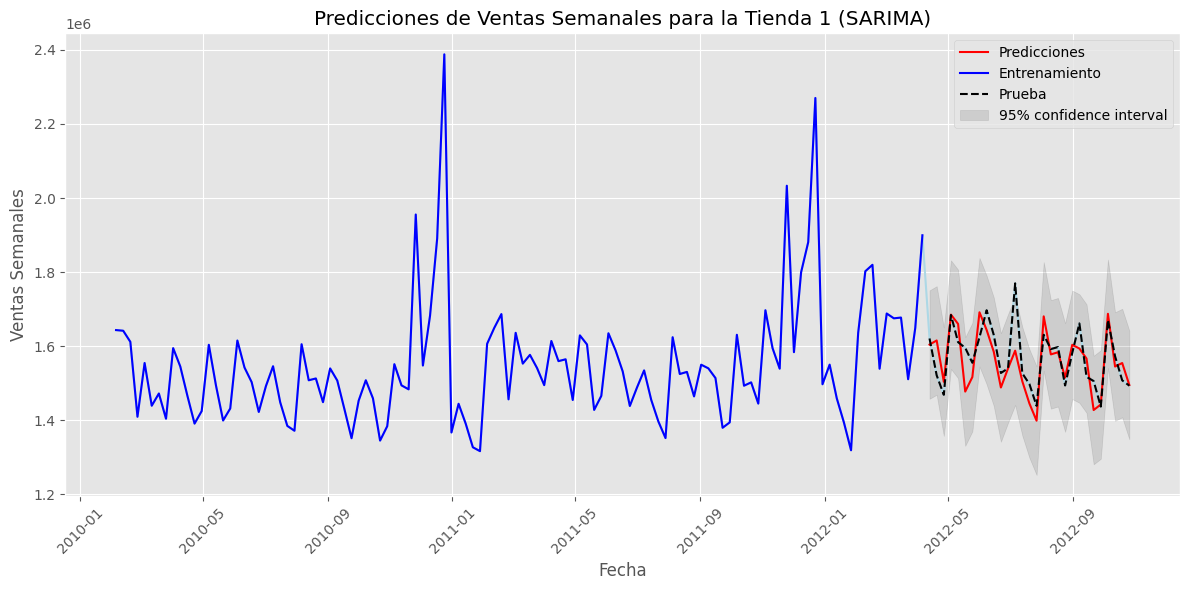

RMSE (SARIMA): 57920.78436928455


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(train_data['Weekly_Sales'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end=len(store1_data) - 1)
pred_ci = model_fit.get_prediction(start=len(train_data), end=len(store1_data) - 1).conf_int()



plt.figure(figsize=(12, 6))
#plt.plot(store1_data['date'], store1_data['Weekly_Sales'], label='Datos reales')
#plt.plot(test_data['date'], predictions, label='Predicciones SARIMA')

plt.plot(store1_data['date'], store1_data['Weekly_Sales'],color="lightblue")
plt.plot(test_data['date'], predictions, label='Predicciones',color="red")
plt.plot(train_data['date'], train_data['Weekly_Sales'],label="Entrenamiento",color='blue')
plt.plot(test_data['date'], test_data['Weekly_Sales'], label='Prueba',ls="--",color='black')


plt.fill_between(test_data['date'], pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.1, label='95% confidence interval')


plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales')
plt.title('Predicciones de Ventas Semanales para la Tienda 1 (SARIMA)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rmse_SARIMA = math.sqrt(mean_squared_error(test_data['Weekly_Sales'], predictions))
print(f'RMSE (SARIMA): {rmse_SARIMA}')


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -778.894
Date:                            Thu, 08 May 2025   AIC                           1567.787
Time:                                    23:17:31   BIC                           1578.423
Sample:                                         0   HQIC                          1571.963
                                            - 114                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3722      1.738      0.214      0.830      -3.035       3.779
ma.L1         -0.4082      1.633     -0.250      0.803      -3.609       2.793
ar.S.L52       0.9885      0.199      4.976      0.000       0.599       1.378
ma.S.L52      -0.9685      0.307     -3.156      0.002      -1.570      -0.367
sigma2      5.495e+09   1.71e-10   3.21e+19      0.000     5.5e+09     5.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):                 7.55
Prob(Q):                              0.20   Prob(JB):                         0.02
Heteroskedasticity (H):               2.37   Skew:                             0.11
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+37. Standard errors may be unstable.
"""

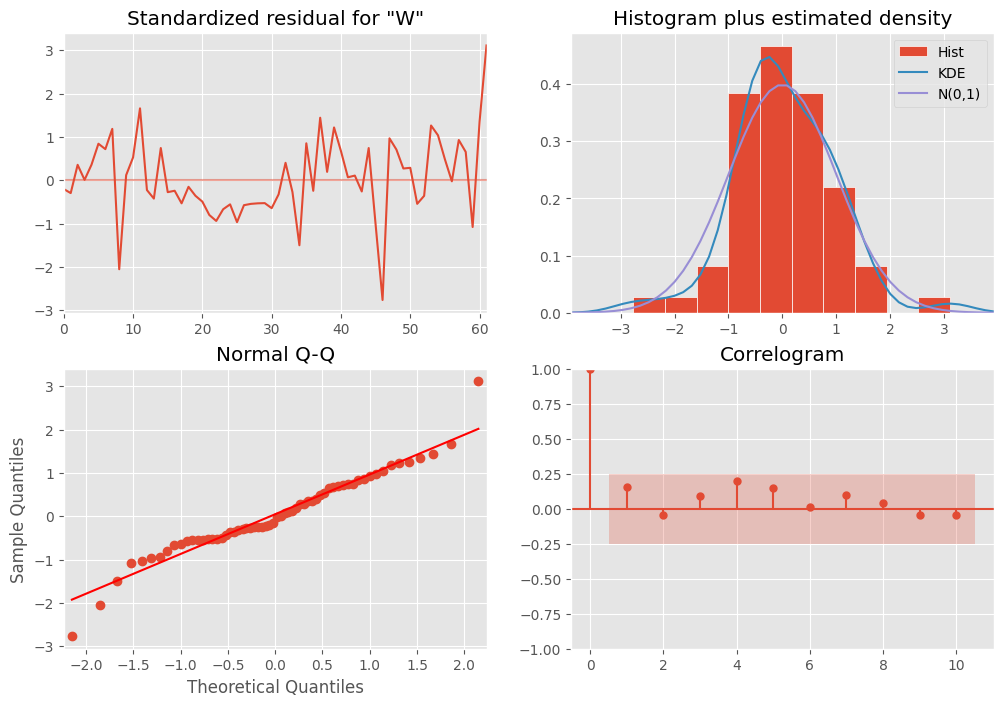

In [ ]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

## skforecast

https://skforecast.org/0.16.0/

In [ ]:
pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.9 MB/s eta 0:00:00


In [ ]:
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

In [ ]:
model = Sarimax(order=(1, 0, 1), seasonal_order=(1, 1, 1, 52))
model_sk=model.fit(y=train_data['Weekly_Sales'])
model.summary()
# Prediction
# ==============================================================================
predictions_skforecast = model.predict(steps=len(test_data['Weekly_Sales']))
predictions_skforecast.columns = ['skforecast']
display(predictions_skforecast.head(4))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,skforecast
114,1.604582e+06
115,1.615651e+06
116,1.504261e+06
117,1.685426e+06


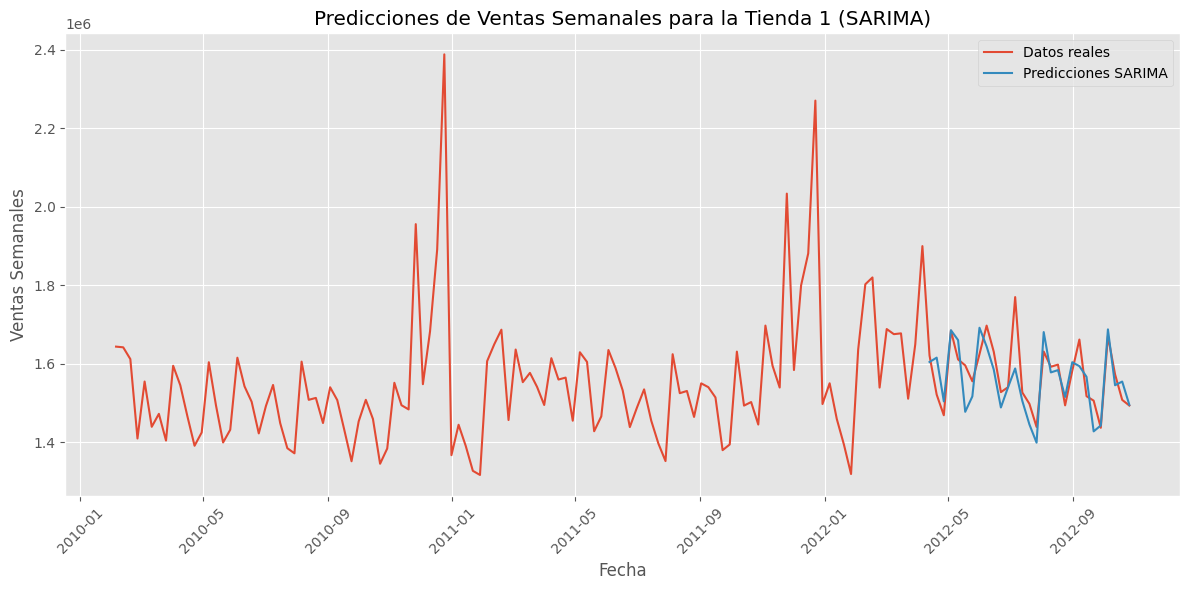

RMSE (SARIMA): 57920.78436928455


In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(store1_data['date'], store1_data['Weekly_Sales'], label='Datos reales')
plt.plot(test_data['date'], predictions_skforecast, label='Predicciones SARIMA')



plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales')
plt.title('Predicciones de Ventas Semanales para la Tienda 1 (SARIMA)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rmse_SARIMA = math.sqrt(mean_squared_error(test_data['Weekly_Sales'], predictions_skforecast))
print(f'RMSE (SARIMA): {rmse_SARIMA}')


In [ ]:
train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)


## Backtesting



In [ ]:
forecaster = ForecasterSarimax(
                 regressor = Sarimax(
                                order          = (1, 0, 1),
                                seasonal_order =(1, 1, 1, 52),
                                maxiter        = 200
                             )
             )
cv = TimeSeriesFold(
        steps              = 35,
        initial_train_size = len(train_data['Weekly_Sales']),
        refit              = False,
        fixed_train_size   = False,

)
metric, predictions = backtesting_sarimax(
                        forecaster            = forecaster,
                        y                     = df['Weekly_Sales'],
                        cv                    = cv,
                        metric                = 'mean_absolute_error',
                        suppress_warnings_fit = True,
                        verbose               = True,
                     )
display(metric)
predictions.head(4)


Information of folds
--------------------
Number of observations used for initial training: 114
Number of observations used for backtesting: 6321
    Number of folds: 181
    Number skipped folds: 0 
    Number of steps per fold: 35
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 21 observations.

Fold: 0
    Training:   0 -- 113  (n=114)
    Validation: 114 -- 148  (n=35)
Fold: 1
    Training:   No training in this fold
    Validation: 149 -- 183  (n=35)
Fold: 2
    Training:   No training in this fold
    Validation: 184 -- 218  (n=35)
Fold: 3
    Training:   No training in this fold
    Validation: 219 -- 253  (n=35)
Fold: 4
    Training:   No training in this fold
    Validation: 254 -- 288  (n=35)
Fold: 5
    Training:   No training in this fold
    Validation: 289 -- 323  (n=35)
Fold: 6
    Training:   No training in this fold
    Validation: 324 -- 358  (n=35)
Fold: 7
    Training:   No training in this

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
df['Weekly_Sales'].loc[train_size:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend();


## Hyperparameter tuning

**Análisis exploratorio y búsqueda de hiperparámetros**

El análisis exploratorio ha logrado reducir el espacio de búsqueda para los hiperparámetros óptimos del modelo. Sin embargo, para determinar definitivamente los valores más adecuados, es esencial utilizar métodos de búsqueda estratégicos. Entre estos métodos, dos enfoques ampliamente utilizados son:

- **Criterios estadísticos**: Los criterios de información, como el Criterio de Información de Akaike (AIC)(https://robjhyndman.com/hyndsight/aic/) o el Criterio de Información Bayesiano (BIC), utilizan diferentes penalizaciones en la estimación de máxima verosimilitud (log-verosimilitud) del modelo como medida de ajuste. La ventaja de utilizar estos criterios es que se calculan solo en los datos de entrenamiento, eliminando la necesidad de predicciones en nuevos datos. Como resultado, el proceso de optimización se acelera significativamente. El conocido algoritmo Auto Arima utiliza este enfoque.


- **Técnicas de validación**: El uso de técnicas de validación, especialmente la validación retrospectiva (backtesting), es otra estrategia efectiva. La validación retrospectiva implica evaluar el rendimiento del modelo utilizando datos históricos para simular condiciones del mundo real. Esto ayuda a validar la efectividad de los hiperparámetros en diferentes escenarios, proporcionando una evaluación práctica de su viabilidad.

**Ventajas y desventajas**

En el primer enfoque, los cálculos se basan solo en los datos de entrenamiento, eliminando la necesidad de predicciones en nuevos datos. Esto hace que el proceso de optimización sea muy rápido. Sin embargo, es importante tener en cuenta que los criterios de información solo miden la calidad relativa de los modelos. Esto significa que todos los modelos probados podrían seguir siendo malos ajustes. Por lo tanto, el modelo seleccionado finalmente debe someterse a una fase de validación retrospectiva. Esta fase calcula una métrica (como MAE, MSE, MAPE, etc.) que valida su rendimiento en una escala significativa.
Por otro lado, el segundo enfoque - técnicas de validación - tiende a ser más lento, ya que el modelo debe entrenarse y luego evaluarse en nuevos datos. Sin embargo, los resultados generados son a menudo más robustos, y las métricas derivadas pueden proporcionar conocimientos más profundos.

**Notas**

Al evaluar modelos ARIMA-SARIMAX, es importante tener en cuenta que el AIC asume que todos los modelos se entrenan con los mismos datos. Por lo tanto, utilizar el AIC para decidir entre diferentes órdenes de diferenciación es técnicamente inválido, ya que se pierde un punto de datos con cada orden de diferenciación. Por esta razón, el algoritmo Auto Arima utiliza una prueba de raíz unitaria para seleccionar el orden de diferenciación, y solo utiliza el AIC para seleccionar el orden de los componentes AR y MA.
Esto se debe a que la prueba de raíz unitaria puede determinar si una serie temporal es estacionaria o no, y por lo tanto, si se requiere diferenciación. Una vez que se ha determinado el orden de diferenciación, el AIC se puede utilizar para comparar modelos con diferentes órdenes de componentes AR y MA, ya que todos los modelos se entrenan con los mismos datos diferenciados. De esta manera, el algoritmo Auto Arima puede seleccionar los hiperparámetros óptimos para el modelo ARIMA-SARIMAX de manera más precisa y eficiente.


**AUTO ARIMA**

At the time of writing this document, pmdarima is only compatible with numpy version lower than 2.0. If you have a higher version, you can downgrade it by running the following command: pip install numpy==1.26.4

In [ ]:
!pip install "numpy<2"

!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.4 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima



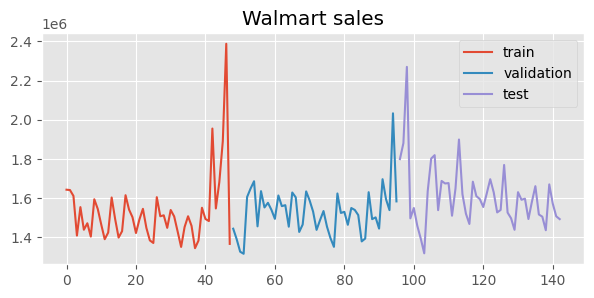

In [ ]:
train_size = int(len(store1_data) * 0.34)
val_size = int((len(store1_data)-train_size)*0.51)
train_data = store1_data[:train_size]

val_data = store1_data[train_size:train_size+val_size]
test_data = store1_data[train_size+val_size:]

fig, ax=plt.subplots(figsize=(7, 3))
train_data['Weekly_Sales'].plot(ax=ax, label='train')
val_data['Weekly_Sales'].plot(ax=ax,label="validation")
test_data['Weekly_Sales'].plot(ax=ax, label='test')
ax.set_title('Walmart sales')
ax.legend();

In [ ]:
train_data.set_index('date', inplace=True)
val_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

In [ ]:
train_data.tail()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
date,,,,,,,
2010-12-03,1,1548033.78,0,49.27,2.708,211.607193,7.838
2010-12-10,1,1682614.26,0,46.33,2.843,211.465953,7.838
2010-12-17,1,1891034.93,0,49.84,2.869,211.405312,7.838
2010-12-24,1,2387950.20,0,52.33,2.886,211.405122,7.838
2010-12-31,1,1367320.01,1,48.43,2.943,211.404932,7.838


In [ ]:
val_data.tail()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
date,,,,,,,
2011-11-04,1,1697229.58,0,54.98,3.332,217.837382,7.866
2011-11-11,1,1594938.89,0,59.11,3.297,217.998085,7.866
2011-11-18,1,1539483.70,0,62.25,3.308,218.220509,7.866
2011-11-25,1,2033320.66,1,60.14,3.236,218.467621,7.866
2011-12-02,1,1584083.95,0,48.91,3.172,218.714733,7.866


In [ ]:
# Train-validation-test data
# ======================================================================================
end_train = "2010-12-31 00:00:00"
end_val = "2011-12-02 00:00:00"



In [ ]:
store1_data.set_index('date', inplace=True)

In [ ]:
store1_data = store1_data.asfreq('W-Fri',fill_value=np.nan)


In [ ]:
store1_data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...
2012-09-28,1,1437059.26,0,76.08,3.666,222.981658,6.908
2012-10-05,1,1670785.97,0,68.55,3.617,223.181477,6.573
2012-10-12,1,1573072.81,0,62.99,3.601,223.381296,6.573


In [ ]:
# Grid search based on backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor = Sarimax(
                                order   = (1, 0, 1), # Placeholder replaced in the grid search
                                maxiter = 500
                             )
             )

param_grid = {
    'order': [(1,0,1),(1,1,1)],
    'seasonal_order': [(1,1,1,52),(0,1,0,52)],
    'trend': [None, 'n', 'c']
}

cv = TimeSeriesFold(
        steps              = 35,
        initial_train_size = len(train_data['Weekly_Sales']),
        refit              = True,
        fixed_train_size   = False,
)

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = store1_data['Weekly_Sales'].loc[:end_val],
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   suppress_warnings_fit = True,
               )
results_grid.head(5)


Number of models compared: 12.


params grid:   0%|          | 0/12 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
0,"{'order': (1, 0, 1), 'seasonal_order': (1, 1, ...",158216.921702,"(1, 0, 1)","(1, 1, 1, 52)",None
1,"{'order': (1, 0, 1), 'seasonal_order': (1, 1, ...",158216.921702,"(1, 0, 1)","(1, 1, 1, 52)",n
2,"{'order': (1, 0, 1), 'seasonal_order': (0, 1, ...",158379.426787,"(1, 0, 1)","(0, 1, 0, 52)",c
3,"{'order': (1, 0, 1), 'seasonal_order': (0, 1, ...",166231.771037,"(1, 0, 1)","(0, 1, 0, 52)",None
4,"{'order': (1, 0, 1), 'seasonal_order': (0, 1, ...",166231.771037,"(1, 0, 1)","(0, 1, 0, 52)",n


In [ ]:
model = auto_arima(
            y                 = store1_data['Weekly_Sales'].loc[:end_val],
            start_p           = 1,
            start_q           = 1,
            max_p             = 2,
            max_q             = 2,
            start_P           = 1,
            start_Q           = 1,
            max_P             = 1,
            max_Q             = 1,
            seasonal          = True,
            test              = 'adf',
            m                 = 52,   # Seasonal period
            d                 = 0,
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (44) is shorter than m (52). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite'

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=1096.706, Time=27.23 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1090.734, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1093.322, Time=3.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1093.193, Time=6.16 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1126.831, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1092.729, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1092.729, Time=0.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=25.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1091.986, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1091.197, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1092.898, Time=1.53 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 67.191 seconds


El pronóstico con un modelo ARIMA se vuelve desafiante cuando los datos del horizonte de pronóstico no siguen inmediatamente al último valor observado durante la fase de entrenamiento. Esta complejidad se debe al componente de media móvil (MA), que se basa en errores de pronóstico pasados como predictores. Por lo tanto, para predecir en el momento y, el error de la predicción t-1 se vuelve una necesidad. En situaciones en las que esta predicción no está disponible, el error correspondiente permanece no disponible. Por esta razón, en la mayoría de los casos, los modelos ARIMA se reentrenan cada vez que se necesitan hacer predicciones.
A pesar de los considerables esfuerzos y avances para acelerar el proceso de entrenamiento para estos modelos, no siempre es factible reentrenar el modelo entre predicciones, ya sea debido a restricciones de tiempo o recursos computacionales insuficientes para acceder repetidamente a los datos históricos. Un enfoque intermedio es alimentar al modelo con datos desde la última observación de entrenamiento hasta el inicio de la fase de predicción. Esta técnica permite estimar predicciones intermedias y, como resultado, los errores necesarios. Por ejemplo, imagine una situación en la que un modelo se entrenó hace 20 días con datos diarios de los últimos tres años. Al generar nuevas predicciones, solo se necesitarían los 20 valores más recientes, en lugar del conjunto de datos históricos completo (365 * 3 + 20).
Integrar nuevos datos en el modelo puede ser complejo, pero la clase ForecasterSarimax simplifica esto considerablemente al automatizar el proceso a través del argumento last_window en su método predict.

In [ ]:
train_data.tail()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
date,,,,,,,
2012-03-09,1,1675431.16,0,58.76,3.669,221.059189,7.348
2012-03-16,1,1677472.78,0,64.74,3.734,221.211813,7.348
2012-03-23,1,1511068.07,0,65.93,3.787,221.286413,7.348
2012-03-30,1,1649604.63,0,67.61,3.845,221.361012,7.348
2012-04-06,1,1899676.88,0,70.43,3.891,221.435611,7.143


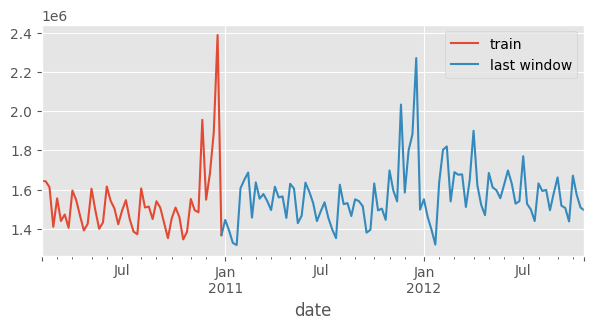

In [ ]:
# Split data Train - Last window
# ==============================================================================
end_train = '2010-12-31 00:00:00'

fig, ax = plt.subplots(figsize=(7, 3))
store1_data['Weekly_Sales'].loc[:end_train].plot(ax=ax, label='train')
store1_data['Weekly_Sales'].loc[end_train:].plot(ax=ax, label='last window')
ax.set_title('')
ax.legend();


El Forecaster se entrena utilizando datos hasta '2010-12-31' y luego utilizará la información restante como la última ventana de observaciones para generar nuevas predicciones.


In [ ]:
forecaster = ForecasterSarimax(
                regressor = Sarimax(
                    order          = (0, 1, 1),
                    seasonal_order = (1, 1, 1, 12),
                    maxiter        = 500
                )
)
forecaster.fit(y=store1_data['Weekly_Sales'].loc[:end_train])

Predicción para 12 steps:

In [ ]:
end_train

'2010-12-31 00:00:00'

In [ ]:
predictions = forecaster.predict(
                  steps       = 12,
                  last_window = store1_data['Weekly_Sales'].loc["2011-01-07":]
              )
predictions.head(3)

,pred
2012-11-02,1.490979e+06
2012-11-09,1.505229e+06
2012-11-16,1.431402e+06


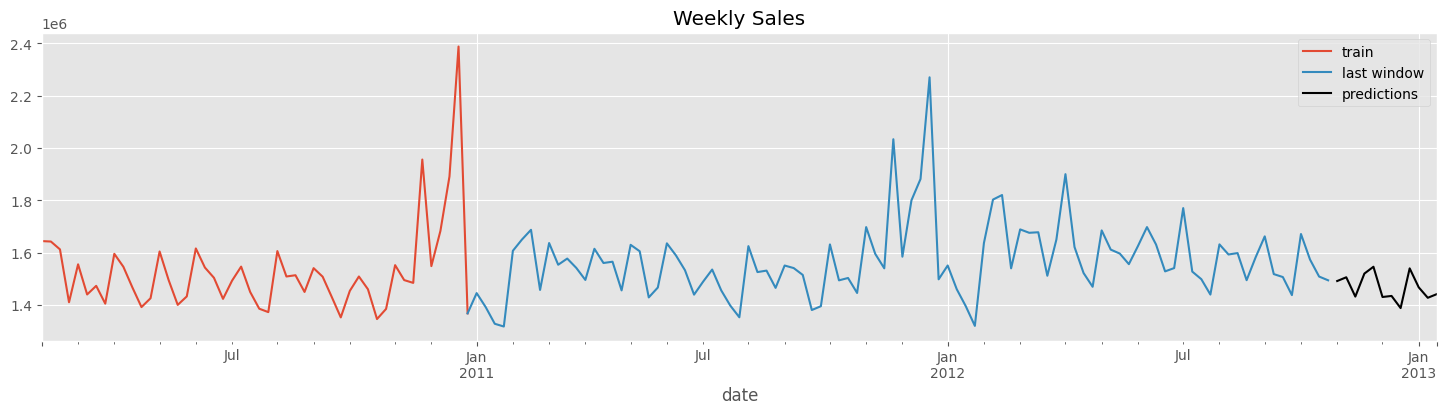

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
store1_data['Weekly_Sales'].loc[:end_train].plot(ax=ax, label='train')
store1_data['Weekly_Sales'].loc[end_train:].plot(ax=ax, label='last window')
predictions.plot(ax=ax, label='predictions',color="black")
ax.set_title('Weekly Sales')
ax.legend()


# Análisis con modelos de regresión

In [ ]:
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05
...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,2012-09-28
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,2012-10-05
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,2012-10-12
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,2012-10-19


<ipython-input-80-3c88938e19b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1_data['time'] = time


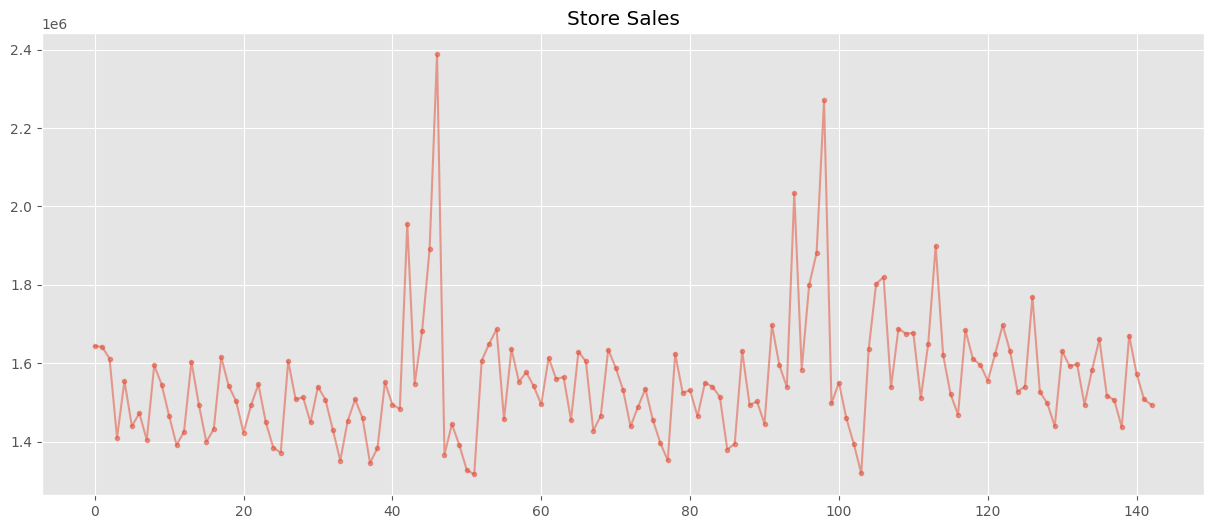

In [ ]:
time = np.arange(len(store1_data.index))

store1_data['time'] = time

X = store1_data.loc[:,['time']]  # features
y = store1_data.loc[:,'Weekly_Sales']  # target

fig, ax = plt.subplots(figsize=(15,6))
y.plot(alpha=0.5,marker='.')
ax.set_title('Store Sales');


In [ ]:
from sklearn.linear_model import LinearRegression


# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)



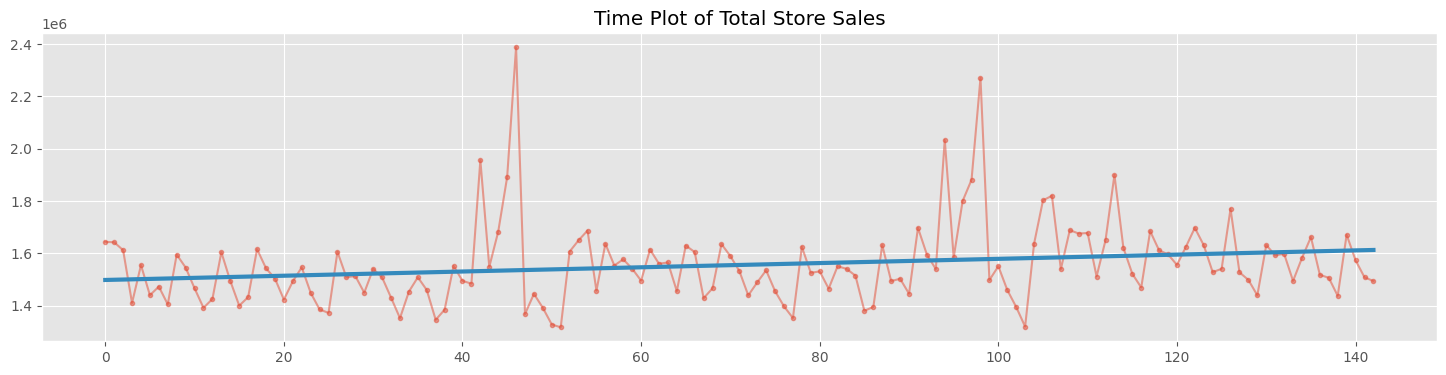

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))
ax = y.plot(alpha=0.5,marker='.')
ax = y_pred.plot(ax=ax, linewidth=3)
plt.x_label_1 = 'Index'
plt.y_label_1 = 'Sales'
ax.set_title('Time Plot of Total Store Sales');

-------------------------------------------------------------------------------

# 4) Fit a lag feature to Store Sales

Create a linear regression model with a lag feature on the series of average product sales. The target is in a column of `df` called `'sales'`.

In [ ]:
lag_1 = store1_data['Weekly_Sales'].shift(1)
store1_data['lag_1'] = lag_1  # add to dataframe
store1_data.head(10)


<ipython-input-83-4ee783b36071>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1_data['lag_1'] = lag_1  # add to dataframe


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date,time,lag_1
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05,0,NaN
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12,1,1643690.90
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19,2,1641957.44
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26,3,1611968.17
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05,4,1409727.59
5,1,1439541.59,0,57.79,2.667,211.380643,8.106,2010-03-12,5,1554806.68
6,1,1472515.79,0,54.58,2.720,211.215635,8.106,2010-03-19,6,1439541.59
7,1,1404429.92,0,51.45,2.732,211.018042,8.106,2010-03-26,7,1472515.79
8,1,1594968.28,0,62.27,2.719,210.820450,7.808,2010-04-02,8,1404429.92
9,1,1545418.53,0,65.86,2.770,210.622857,7.808,2010-04-09,9,1594968.28


In [ ]:
store1_data[['Weekly_Sales','lag_1']].head()

,Weekly_Sales,lag_1
0,1643690.90,NaN
1,1641957.44,1643690.90
2,1611968.17,1641957.44
3,1409727.59,1611968.17
4,1554806.68,1409727.59


In [ ]:
X = store1_data.loc[:, ['lag_1']].dropna()  # features
y = store1_data.loc[:, 'Weekly_Sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target



In [ ]:

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X,y)

# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)



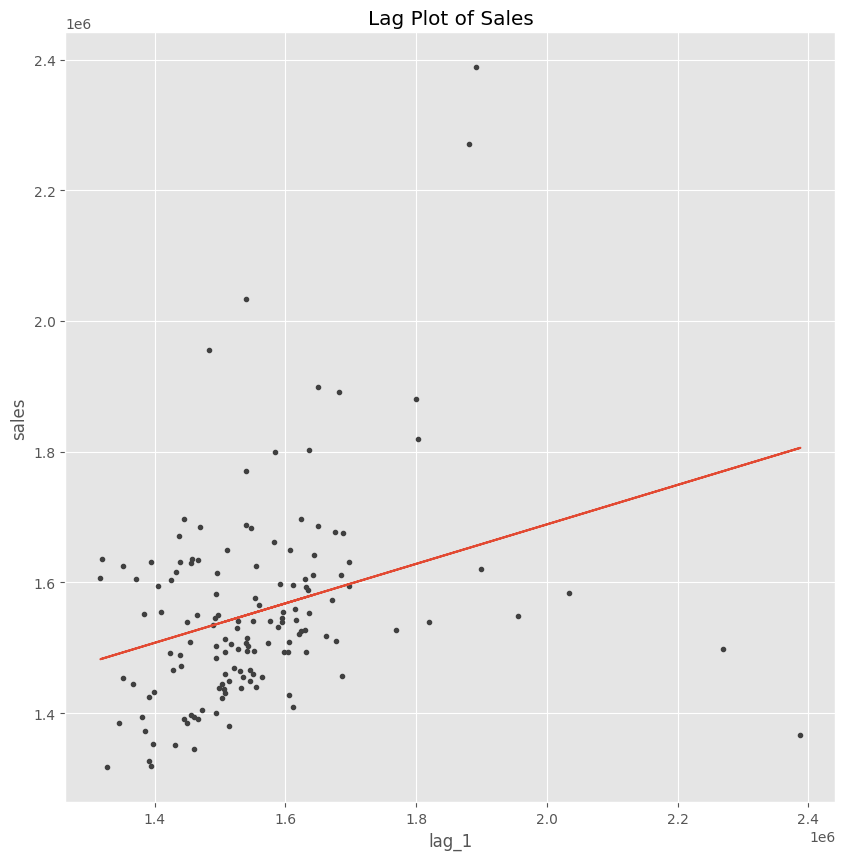

In [ ]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Sales');

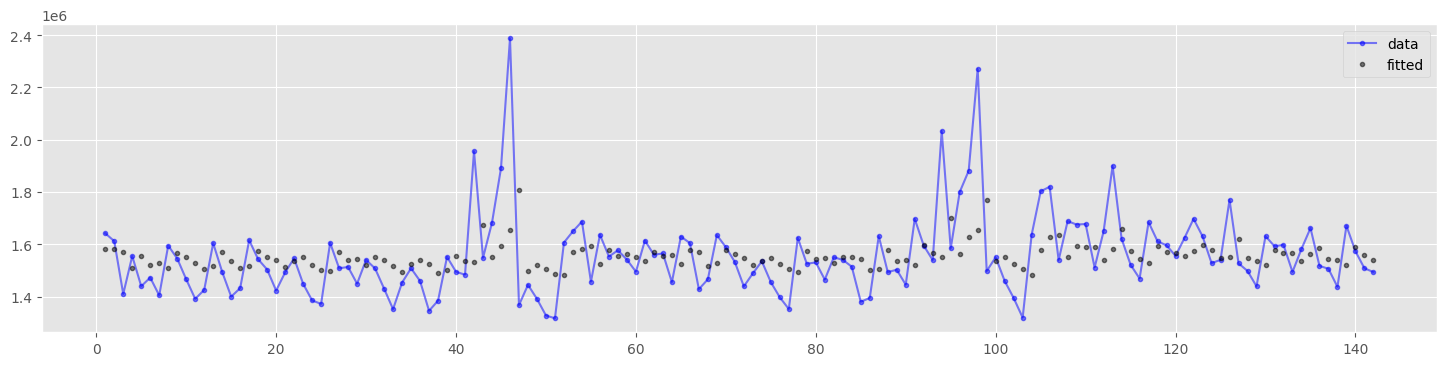

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))
ax = y.plot(marker='.',color='b',alpha=0.5,label='data')
ax = y_pred.plot(marker='.',color='k',alpha=0.5,ls='none',label='fitted')
ax.legend()

In [ ]:
lag_2 = store1_data['Weekly_Sales'].shift(2)
store1_data['lag_2'] = lag_2  # add to dataframe
store1_data.head(10)

<ipython-input-89-0cd7c488a75b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1_data['lag_2'] = lag_2  # add to dataframe


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date,time,lag_1,lag_2
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05,0,NaN,NaN
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12,1,1643690.90,NaN
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19,2,1641957.44,1643690.90
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26,3,1611968.17,1641957.44
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05,4,1409727.59,1611968.17
5,1,1439541.59,0,57.79,2.667,211.380643,8.106,2010-03-12,5,1554806.68,1409727.59
6,1,1472515.79,0,54.58,2.720,211.215635,8.106,2010-03-19,6,1439541.59,1554806.68
7,1,1404429.92,0,51.45,2.732,211.018042,8.106,2010-03-26,7,1472515.79,1439541.59
8,1,1594968.28,0,62.27,2.719,210.820450,7.808,2010-04-02,8,1404429.92,1472515.79
9,1,1545418.53,0,65.86,2.770,210.622857,7.808,2010-04-09,9,1594968.28,1404429.92


In [ ]:
store1_data[['Weekly_Sales','lag_1','lag_2']].head()

,Weekly_Sales,lag_1,lag_2
0,1643690.90,NaN,NaN
1,1641957.44,1643690.90,NaN
2,1611968.17,1641957.44,1643690.90
3,1409727.59,1611968.17,1641957.44
4,1554806.68,1409727.59,1611968.17


In [ ]:
X = store1_data.loc[:, ['lag_2']].dropna()  # features
y = store1_data.loc[:, 'Weekly_Sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target


In [ ]:
# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X,y)

# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

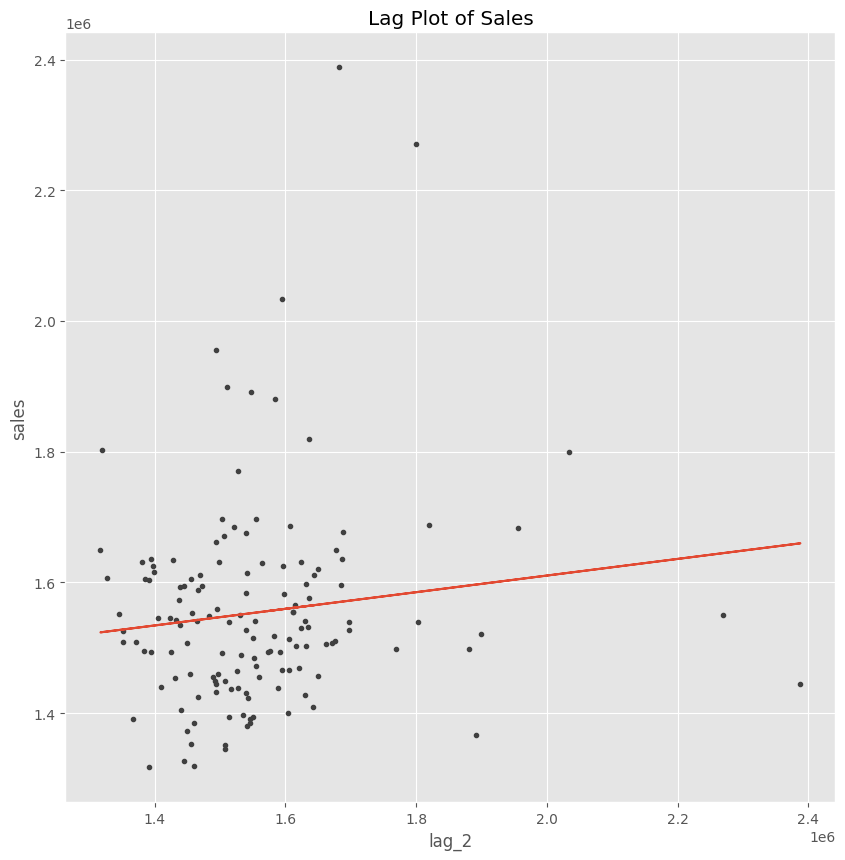

In [ ]:
fig, ax = plt.subplots()
ax.plot(X['lag_2'], y, '.', color='0.25')
ax.plot(X['lag_2'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_2', title='Lag Plot of Sales');

## Feature engineering y variables exógenas

Explanation about "rolling" in pandas
https://www.youtube.com/watch?app=desktop&v=FYji-5S8D2s



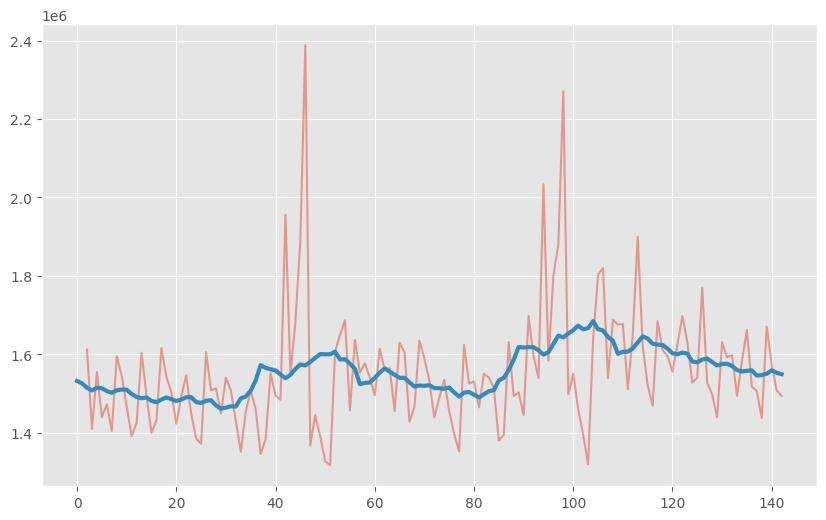

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

trend = store1_data['Weekly_Sales'].rolling(
    window=20,
    center=True,
    min_periods=10,
).mean()

ax =y.plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# 3) Create a Trend Feature

Use `DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

# appropriate for a cubic trend model
dp = DeterministicProcess(index=y.index, order=3)

X = dp.in_sample()  # in sample- training set

X_fore =dp.out_of_sample(steps=90) #out-of sample: test

In [ ]:
X_fore.head()

,trend,trend_squared,trend_cubed
143,142.0,20164.0,2863288.0
144,143.0,20449.0,2924207.0
145,144.0,20736.0,2985984.0
146,145.0,21025.0,3048625.0
147,146.0,21316.0,3112136.0


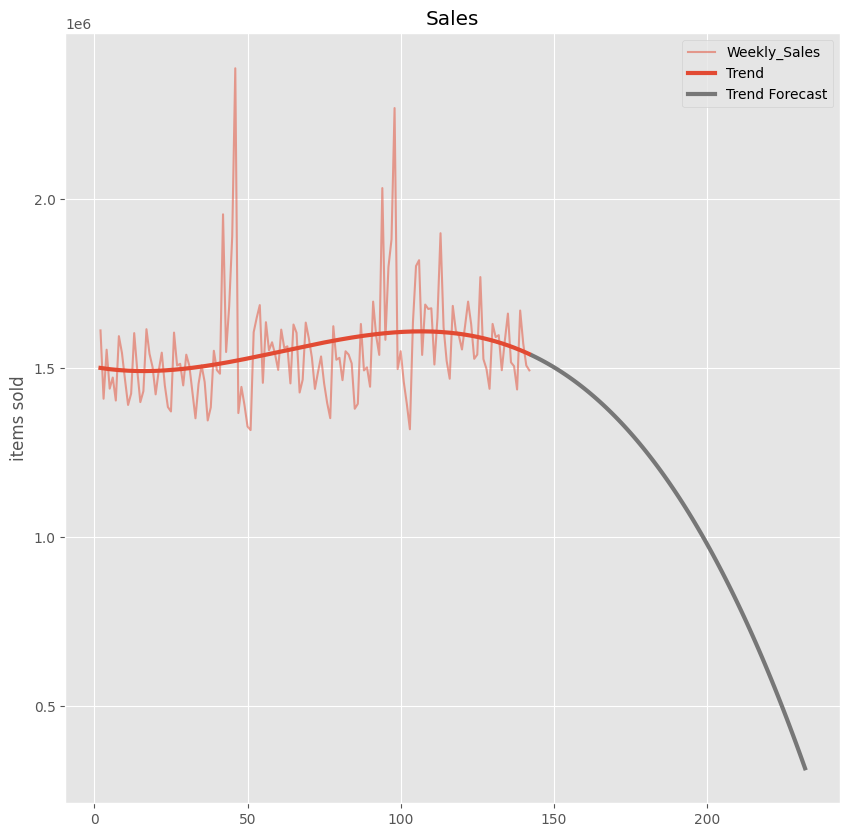

In [ ]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

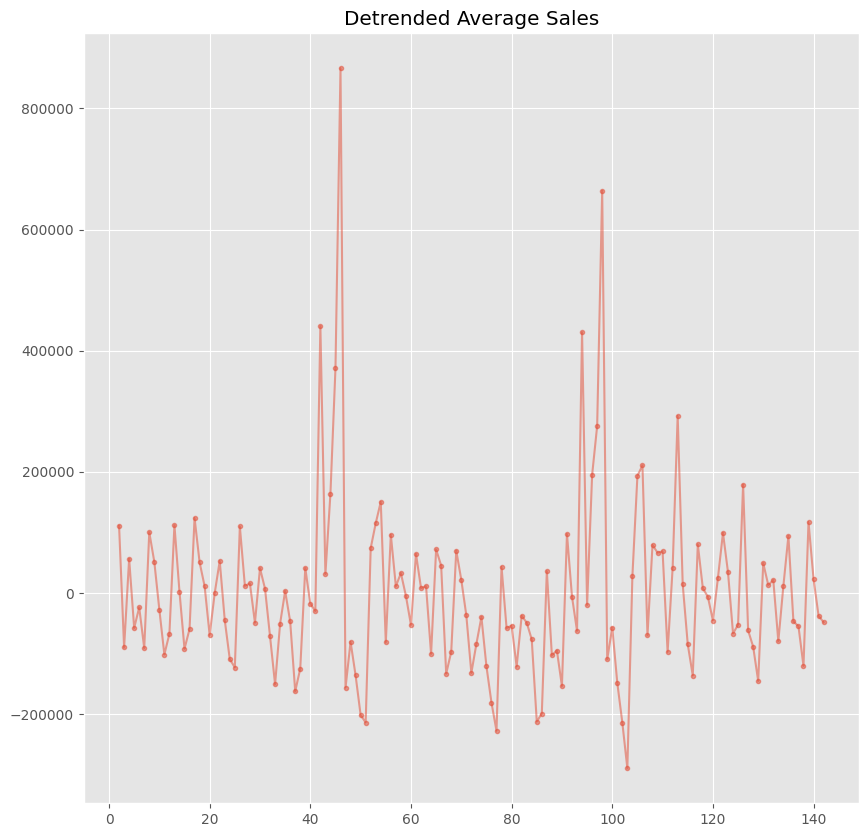

In [ ]:
y_detrended = y - y_pred   # remove the trend from store_sales
y_detrended.plot( title="Detrended Average Sales",marker='.',alpha=0.5);

## Feature engineering y variables exógenas

# Estacionalidad

Usaremos `DeterministicProcess` y `CalendarFourier` para crear:
- indicadores de estacionalidad semanal y
- features de Fourier de orden 4 para estacionalidad mensual.

In [ ]:
store1_data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date,time,lag_1,lag_2
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05,0,NaN,NaN
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12,1,1643690.90,NaN
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19,2,1641957.44,1643690.90
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26,3,1611968.17,1641957.44
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05,4,1409727.59,1611968.17


In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=pd.to_datetime(store1_data['date'], format='%d-%m-%Y'),
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [ ]:
X

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.587785,0.809017,-0.951057,0.309017,-0.951057,-0.309017,-0.587785,-0.809017
2012-10-05,1.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
2012-10-12,1.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347


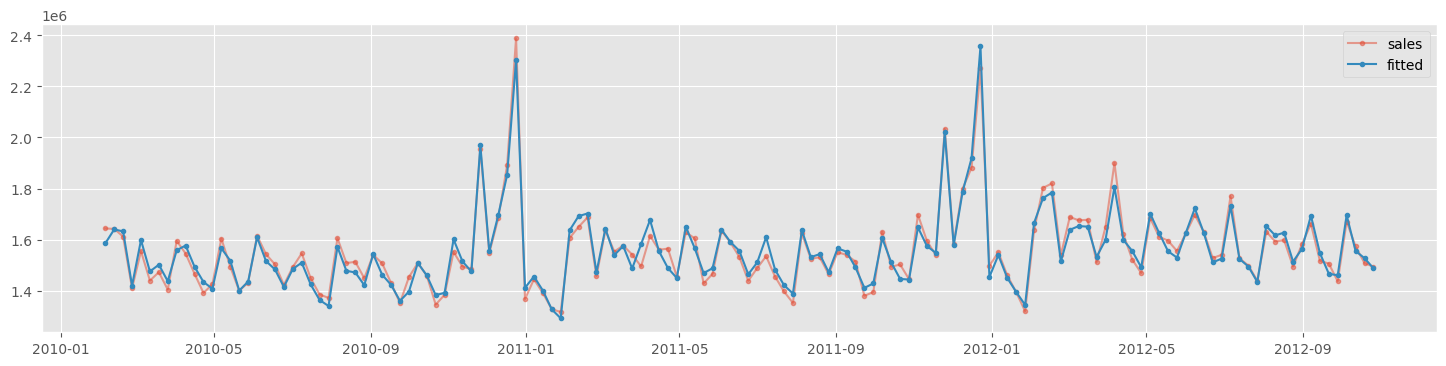

In [ ]:
model_seasonal = LinearRegression().fit(X, store1_data['Weekly_Sales'])
y_pred_seasonal = pd.Series(
    model_seasonal.predict(X),
    index=X.index,
    name='Fitted',
)

fig, ax = plt.subplots(figsize=(18,4))
ax.plot(store1_data['date'],store1_data['Weekly_Sales'],alpha=0.5, marker='.',label="sales")
ax.plot(y_pred_seasonal,label='fitted',marker='.')
ax.legend()

In [ ]:
rmse_seasonal = math.sqrt(mean_squared_error(store1_data['Weekly_Sales'], y_pred_seasonal))
print(f'RMSE: {rmse_seasonal}')

RMSE: 31602.826061483895


In [ ]:
X.columns

Index(['const', 'trend', 's(2,52)', 's(3,52)', 's(4,52)', 's(5,52)', 's(6,52)',
       's(7,52)', 's(8,52)', 's(9,52)', 's(10,52)', 's(11,52)', 's(12,52)',
       's(13,52)', 's(14,52)', 's(15,52)', 's(16,52)', 's(17,52)', 's(18,52)',
       's(19,52)', 's(20,52)', 's(21,52)', 's(22,52)', 's(23,52)', 's(24,52)',
       's(25,52)', 's(26,52)', 's(27,52)', 's(28,52)', 's(29,52)', 's(30,52)',
       's(31,52)', 's(32,52)', 's(33,52)', 's(34,52)', 's(35,52)', 's(36,52)',
       's(37,52)', 's(38,52)', 's(39,52)', 's(40,52)', 's(41,52)', 's(42,52)',
       's(43,52)', 's(44,52)', 's(45,52)', 's(46,52)', 's(47,52)', 's(48,52)',
       's(49,52)', 's(50,52)', 's(51,52)', 's(52,52)', 'sin(1,freq=ME)',
       'cos(1,freq=ME)', 'sin(2,freq=ME)', 'cos(2,freq=ME)', 'sin(3,freq=ME)',
       'cos(3,freq=ME)', 'sin(4,freq=ME)', 'cos(4,freq=ME)'],
      dtype='object')

## Calendar features

In [ ]:
X['day']=np.array(pd.to_datetime(store1_data['date']).dt.day)
X['month']=np.array(pd.to_datetime(store1_data['date']).dt.month)
X['year']=np.array(pd.to_datetime(store1_data['date']).dt.year)
X['dayofweek']=np.array(pd.to_datetime(store1_data['date']).dt.dayofweek)


In [ ]:
X

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.587785,0.809017,-0.951057,0.309017,-0.951057,-0.309017,-0.587785,-0.809017
2012-10-05,1.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
2012-10-12,1.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347


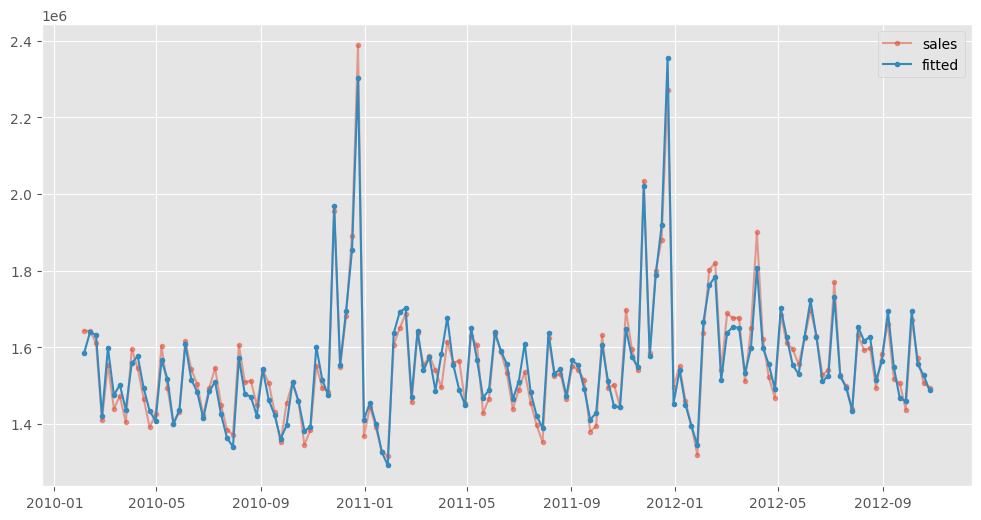

In [ ]:
model_calendar = LinearRegression().fit(X, store1_data['Weekly_Sales'])
y_pred_calendar = pd.Series(
    model_calendar.predict(X),
    index=X.index,
    name='Fitted',
)

#y_pred = pd.Series(model.predict(X), index=X.index)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(store1_data['date'],store1_data['Weekly_Sales'],alpha=0.5, marker='.',label="sales")
ax.plot(y_pred_calendar,label='fitted',marker='.')
ax.legend();

In [ ]:
import math
rmse_calendar = math.sqrt(mean_squared_error(store1_data['Weekly_Sales'], y_pred_calendar))
print(f'RMSE: {rmse_calendar}')

RMSE: 31602.826061483895


In [ ]:
X['holidays']=np.array(store1_data['Holiday_Flag'])

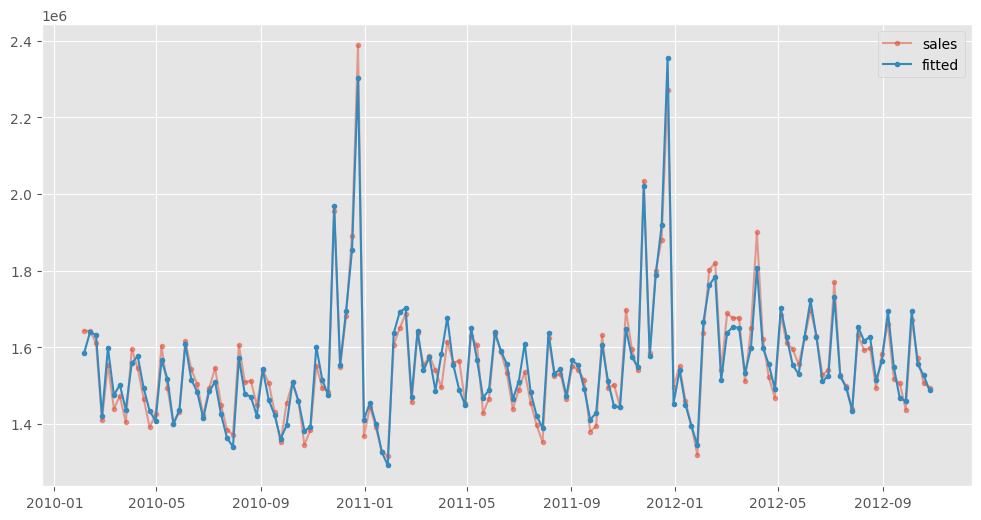

In [ ]:
model_holidays = LinearRegression().fit(X, store1_data['Weekly_Sales'])
y_pred_holidays = pd.Series(
    model_holidays.predict(X),
    index=X.index,
    name='Fitted',
)

#y_pred = pd.Series(model.predict(X), index=X.index)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(store1_data['date'],store1_data['Weekly_Sales'],alpha=0.5, marker='.',label="sales")
ax.plot(y_pred_holidays,label='fitted',marker='.')
ax.legend();

In [ ]:
rmse_holidays = math.sqrt(mean_squared_error(store1_data['Weekly_Sales'], y_pred_holidays))
print(f'RMSE: {rmse_holidays}')

RMSE: 31602.826061483902


In [ ]:
X['temp']=np.array(store1_data['Temperature'])

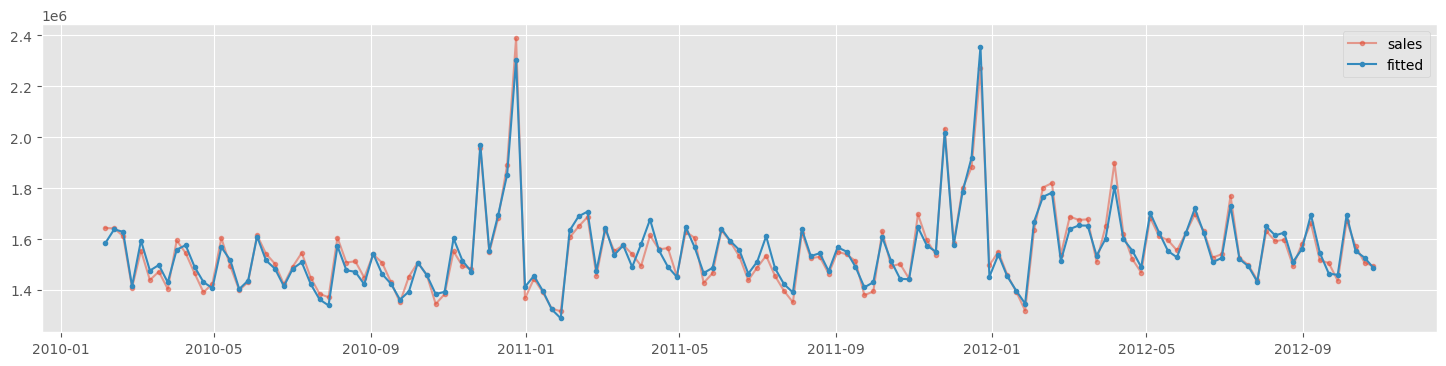

In [ ]:
model_temperature = LinearRegression().fit(X, store1_data['Weekly_Sales'])
y_pred_temperature = pd.Series(
    model_temperature.predict(X),
    index=X.index,
    name='Fitted',
)

#y_pred = pd.Series(model.predict(X), index=X.index)
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(store1_data['date'],store1_data['Weekly_Sales'],alpha=0.5, marker='.',label="sales")
ax.plot(y_pred_temperature,label='fitted',marker='.')
ax.legend();

In [ ]:
rmse_temperature = math.sqrt(mean_squared_error(store1_data['Weekly_Sales'], y_pred_temperature))
print(f'RMSE: {rmse_temperature}')

RMSE: 31536.961368930934


In [ ]:
X['fuel']=np.array(store1_data['Fuel_Price'])

In [ ]:
X

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",holidays,temp,fuel
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,0,42.31,2.572
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969,1,38.51,2.548
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969,0,39.93,2.514
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969,0,46.63,2.561
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,0,46.50,2.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.587785,0.809017,-0.951057,0.309017,-0.951057,-0.309017,-0.587785,-0.809017,0,76.08,3.666
2012-10-05,1.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,0,68.55,3.617
2012-10-12,1.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,0,62.99,3.601


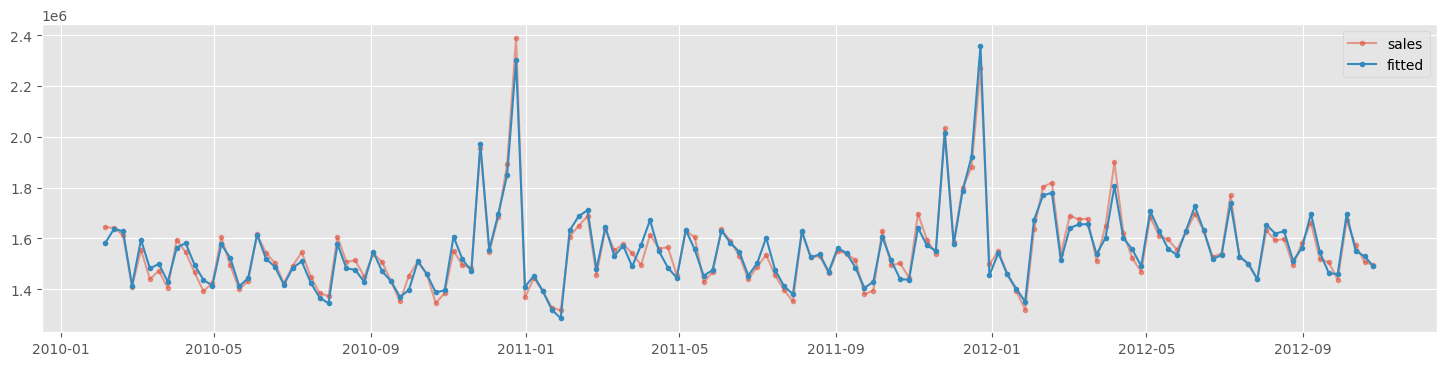

In [ ]:
model_fuel = LinearRegression().fit(X, store1_data['Weekly_Sales'])
y_pred_fuel = pd.Series(
    model_fuel.predict(X),
    index=X.index,
    name='Fitted',
)

#y_pred = pd.Series(model.predict(X), index=X.index)
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(store1_data['date'],store1_data['Weekly_Sales'],alpha=0.5, marker='.',label="sales")
ax.plot(y_pred_fuel,label='fitted',marker='.')
ax.legend();

In [ ]:
rmse_fuel = math.sqrt(mean_squared_error(store1_data['Weekly_Sales'], y_pred_fuel))
print(f'RMSE: {rmse_fuel}')

RMSE: 31080.20070769344


In [ ]:

data = {
    'Model': ['model_seasonal', 'model_calendar', 'model_holidays', 'model_temperature', 'model_fuel'],
    'RMSE': [rmse_seasonal, rmse_calendar, rmse_holidays, rmse_temperature, rmse_fuel]
}

df_rmse = pd.DataFrame(data)
df_rmse


,Model,RMSE
0,model_seasonal,31602.826061
1,model_calendar,31602.826061
2,model_holidays,31602.826061
3,model_temperature,31536.961369
4,model_fuel,31080.200708


En este ejemplo se enseñó el efecto de variables exógenas en el modelo de regresión, creando el modelo con todos los datos, sin dividirlos en set de entrenamiento y set de prueba. Si quisiéramos evaluar el modelo con datos de prueba, no habría problema para el modelo que incluye las features de calendario, porque éstas se pueden generar para tiempos "futuros" (también la variable "holidays", dado que en general los días oficiales de vacaciones son fijos o son programados).

**¿Pero, cómo se podría hacer para las variables exógenas (temperatura, fuel price) si no se sabe qué valores tendrán en el futuro?**
